cuda
Users' Powers:[-13.454281 -30.943207 -24.49852  -37.66932  -14.917595] dBm ----->> SumPower : -10.867438316345215
Sigma2 Power:-40.0 dBm


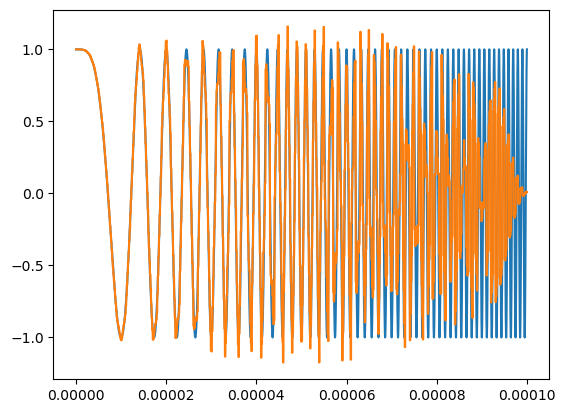

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
snr_db = 30
Ptotal_dbm = 10
comm_pulse_kind = 'CDMA'
radar_pulse_kind = 'LFM'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
snr = 10**(snr_db/10)
Ptotal = 10**((Ptotal_dbm-30)/10)

if comm_pulse_kind=='OFDMA':
    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
    sigma2 = L*Tb/snr

if comm_pulse_kind=='TDMA':
    g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
    sigma2 = L*Tb/snr/K

if comm_pulse_kind=='CDMA':
    g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])
    sigma2 = L*Tb/snr

if radar_pulse_kind=='LFM':
    radar_pulse = myRadarPulses.LFM_pulse(B)

if radar_pulse_kind=='Gaussian':
    radar_pulse = myRadarPulses.Gaussian_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)
user_bit_energy = torch.sum(torch.abs(g_vec)**2, dim=1).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

R = radar_pulse.repeat(K*L, 1)

G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])

c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)
print(f'Users\' Powers:{10*torch.log10(user_energy).cpu().numpy()+30} dBm ----->> SumPower : {10*torch.log10(user_energy.sum()).cpu().numpy()+30}')
print(f'Sigma2 Power:{10*np.log10(sigma2)+30} dBm')

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

cuda


0it [00:00, ?it/s]

Iteration 0: constraint value = -9643.729, Dual Variable = 0.000, Cost = -46.753, UpdateDistance:0.7989927530288696
	----> sumRate = 47.378, MSE = 1.889
Iteration 1000: constraint value = 15.904, Dual Variable = 0.001, Cost = -71.438, UpdateDistance:0.005720613524317741
	----> sumRate = 71.450, MSE = 1.889
Iteration 2000: constraint value = -3.835, Dual Variable = 0.001, Cost = -71.439, UpdateDistance:0.0006690953741781414
	----> sumRate = 71.436, MSE = 1.889


1it [00:28, 28.83s/it]

Early Stopping
====END 2439: constraint value = -2.133, Dual Variable = 0.001, Cost = -71.439, UpdateDistance:4.449725565791596e-06
	----> sumRate = 71.437, MSE = 1.889
Users' Powers:[3.0098171 3.009798  3.0098171 3.0097675 3.0098324] dBm ----->> SumPower : 9.99950885772705
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -5.006, Dual Variable = 0.001, Cost = -64.106, UpdateDistance:0.014498183503746986
	----> sumRate = 71.435, MSE = 1.889
Iteration 1000: constraint value = 1.105, Dual Variable = 0.001, Cost = -64.110, UpdateDistance:0.004553480073809624
	----> sumRate = 71.440, MSE = 1.852
Iteration 2000: constraint value = 0.396, Dual Variable = 0.001, Cost = -64.113, UpdateDistance:0.002288161078467965
	----> sumRate = 71.439, MSE = 1.815
Iteration 3000: constraint value = -0.291, Dual Variable = 0.001, Cost = -64.117, UpdateDistance:0.0019189418526366353
	----> sumRate = 71.439, MSE = 1.780


2it [01:09, 35.88s/it]

Early Stopping
====END 3056: constraint value = 0.211, Dual Variable = 0.001, Cost = -64.117, UpdateDistance:6.928221864654915e-06
	----> sumRate = 71.439, MSE = 1.778
Users' Powers:[3.0207996 3.0181656 3.005371  3.0048733 3.0048904] dBm ----->> SumPower : 10.000525712966919
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -3.168, Dual Variable = 0.001, Cost = -56.795, UpdateDistance:0.017847871407866478
	----> sumRate = 71.437, MSE = 1.778
Iteration 1000: constraint value = 0.799, Dual Variable = 0.001, Cost = -56.810, UpdateDistance:0.006370930466800928
	----> sumRate = 71.439, MSE = 1.705
Iteration 2000: constraint value = -0.180, Dual Variable = 0.001, Cost = -56.824, UpdateDistance:0.0040662856772542
	----> sumRate = 71.439, MSE = 1.635
Iteration 3000: constraint value = 0.032, Dual Variable = 0.001, Cost = -56.838, UpdateDistance:0.003694479586556554
	----> sumRate = 71.439, MSE = 1.566
Iteration 4000: constraint value = -0.006, Dual Variable = 0.001, Cost = -56.851, Update

3it [05:29, 137.96s/it]

Early Stopping
====END 16688: constraint value = 0.031, Dual Variable = 0.001, Cost = -56.963, UpdateDistance:4.575155799102504e-06
	----> sumRate = 71.438, MSE = 0.934
Users' Powers:[3.1151485 3.113121  2.9466152 2.9382935 2.936367 ] dBm ----->> SumPower : 10.000447034835815
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.879, Dual Variable = 0.001, Cost = -49.726, UpdateDistance:0.01571137085556984
	----> sumRate = 71.435, MSE = 0.934
Iteration 1000: constraint value = 0.767, Dual Variable = 0.000, Cost = -49.738, UpdateDistance:0.006354826968163252
	----> sumRate = 71.436, MSE = 0.890
Iteration 2000: constraint value = -0.167, Dual Variable = 0.001, Cost = -49.747, UpdateDistance:0.003602931508794427
	----> sumRate = 71.434, MSE = 0.856
Iteration 3000: constraint value = 0.016, Dual Variable = 0.001, Cost = -49.756, UpdateDistance:0.002897959202528
	----> sumRate = 71.434, MSE = 0.827
Iteration 4000: constraint value = 0.029, Dual Variable = 0.001, Cost = -49.763, UpdateDi

4it [07:02, 120.34s/it]

Early Stopping
====END 5857: constraint value = -0.004, Dual Variable = 0.001, Cost = -49.774, UpdateDistance:8.727596650714986e-06
	----> sumRate = 71.434, MSE = 0.764
Users' Powers:[3.2085972 3.2071476 2.889     2.8691692 2.8642445] dBm ----->> SumPower : 10.000431537628174
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.846, Dual Variable = 0.000, Cost = -42.555, UpdateDistance:0.0153267290443182
	----> sumRate = 71.432, MSE = 0.764
Iteration 1000: constraint value = 0.783, Dual Variable = 0.000, Cost = -42.564, UpdateDistance:0.006938664708286524
	----> sumRate = 71.428, MSE = 0.731
Iteration 2000: constraint value = -0.131, Dual Variable = 0.000, Cost = -42.572, UpdateDistance:0.00370956351980567
	----> sumRate = 71.426, MSE = 0.710
Iteration 3000: constraint value = -0.062, Dual Variable = 0.000, Cost = -42.578, UpdateDistance:0.002626126166433096
	----> sumRate = 71.426, MSE = 0.694
Iteration 4000: constraint value = 0.182, Dual Variable = 0.000, Cost = -42.583, Update

5it [08:53, 116.90s/it]

Early Stopping
====END 6762: constraint value = -0.049, Dual Variable = 0.000, Cost = -42.595, UpdateDistance:3.027788352483185e-06
	----> sumRate = 71.426, MSE = 0.651
Users' Powers:[3.3243656 3.3238068 2.820177  2.7781868 2.7669106] dBm ----->> SumPower : 10.000413656234741
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.824, Dual Variable = 0.000, Cost = -35.387, UpdateDistance:0.014654749073088169
	----> sumRate = 71.424, MSE = 0.651
Iteration 1000: constraint value = 0.797, Dual Variable = 0.000, Cost = -35.394, UpdateDistance:0.007583107799291611
	----> sumRate = 71.414, MSE = 0.627
Iteration 2000: constraint value = -0.068, Dual Variable = 0.000, Cost = -35.398, UpdateDistance:0.003957304637879133
	----> sumRate = 71.411, MSE = 0.615
Iteration 3000: constraint value = -0.131, Dual Variable = 0.000, Cost = -35.402, UpdateDistance:0.0024232470896095037
	----> sumRate = 71.410, MSE = 0.606
Iteration 4000: constraint value = 0.273, Dual Variable = 0.000, Cost = -35.405, Up

6it [10:50, 117.06s/it]

Early Stopping
====END 7049: constraint value = 0.066, Dual Variable = 0.000, Cost = -35.414, UpdateDistance:8.326072929776274e-06
	----> sumRate = 71.410, MSE = 0.582
Users' Powers:[3.4644966 3.464283  2.739048  2.6611214 2.6382236] dBm ----->> SumPower : 10.000463724136353
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.916, Dual Variable = 0.000, Cost = -28.215, UpdateDistance:0.015533827245235443
	----> sumRate = 71.408, MSE = 0.582
Iteration 1000: constraint value = 0.828, Dual Variable = 0.000, Cost = -28.221, UpdateDistance:0.008873109705746174
	----> sumRate = 71.389, MSE = 0.558
Iteration 2000: constraint value = 0.039, Dual Variable = 0.000, Cost = -28.224, UpdateDistance:0.004967784509062767
	----> sumRate = 71.381, MSE = 0.547
Iteration 3000: constraint value = -0.308, Dual Variable = 0.000, Cost = -28.227, UpdateDistance:0.002687203697860241
	----> sumRate = 71.379, MSE = 0.541
Iteration 4000: constraint value = 0.362, Dual Variable = 0.000, Cost = -28.230, Updat

7it [13:16, 126.57s/it]

Early Stopping
====END 8472: constraint value = 0.002, Dual Variable = 0.000, Cost = -28.241, UpdateDistance:1.4075520766709815e-06
	----> sumRate = 71.380, MSE = 0.519
Users' Powers:[3.648449  3.6482525 2.6286602 2.4969463 2.4531345] dBm ----->> SumPower : 10.000433921813965
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.914, Dual Variable = 0.000, Cost = -21.051, UpdateDistance:0.015230155549943447
	----> sumRate = 71.378, MSE = 0.518
Iteration 1000: constraint value = 0.830, Dual Variable = 0.000, Cost = -21.058, UpdateDistance:0.010142064653337002
	----> sumRate = 71.339, MSE = 0.491
Iteration 2000: constraint value = 0.229, Dual Variable = 0.000, Cost = -21.061, UpdateDistance:0.0060636126436293125
	----> sumRate = 71.320, MSE = 0.478
Iteration 3000: constraint value = -0.632, Dual Variable = 0.000, Cost = -21.064, UpdateDistance:0.0032254382967948914
	----> sumRate = 71.313, MSE = 0.472
Iteration 4000: constraint value = 0.638, Dual Variable = 0.000, Cost = -21.066, Up

8it [15:40, 132.10s/it]

Early Stopping
====END 8402: constraint value = -0.076, Dual Variable = 0.000, Cost = -21.075, UpdateDistance:1.6839580894156825e-06
	----> sumRate = 71.312, MSE = 0.455
Users' Powers:[3.9174004 3.9170742 2.4405003 2.2365227 2.1597977] dBm ----->> SumPower : 10.00040054321289
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.752, Dual Variable = 0.000, Cost = -13.898, UpdateDistance:0.01420776266604662
	----> sumRate = 71.310, MSE = 0.455
Iteration 1000: constraint value = 0.711, Dual Variable = 0.000, Cost = -13.908, UpdateDistance:0.011164993047714233
	----> sumRate = 71.227, MSE = 0.421
Iteration 2000: constraint value = 0.564, Dual Variable = 0.000, Cost = -13.912, UpdateDistance:0.007288017310202122
	----> sumRate = 71.178, MSE = 0.404
Iteration 3000: constraint value = -1.185, Dual Variable = 0.000, Cost = -13.915, UpdateDistance:0.003808140754699707
	----> sumRate = 71.152, MSE = 0.395
Iteration 4000: constraint value = 1.306, Dual Variable = 0.000, Cost = -13.917, Updat

9it [17:40, 128.23s/it]

Early Stopping
====END 7153: constraint value = 0.527, Dual Variable = 0.000, Cost = -13.921, UpdateDistance:5.492146101460094e-06
	----> sumRate = 71.133, MSE = 0.381
Users' Powers:[4.3502045 4.349655  2.0664577 1.7481155 1.617548 ] dBm ----->> SumPower : 10.000661611557007
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -2.314, Dual Variable = 0.000, Cost = -6.770, UpdateDistance:0.015362108126282692
	----> sumRate = 71.131, MSE = 0.381
Iteration 1000: constraint value = 0.177, Dual Variable = 0.000, Cost = -6.790, UpdateDistance:0.012592451646924019
	----> sumRate = 70.926, MSE = 0.336
Iteration 2000: constraint value = 1.443, Dual Variable = 0.000, Cost = -6.799, UpdateDistance:0.008266603574156761
	----> sumRate = 70.769, MSE = 0.309
Iteration 3000: constraint value = -2.348, Dual Variable = 0.000, Cost = -6.803, UpdateDistance:0.0035566347651183605
	----> sumRate = 70.658, MSE = 0.292
Iteration 4000: constraint value = 2.527, Dual Variable = 0.000, Cost = -6.805, UpdateDis

10it [22:45, 182.90s/it]

Early Stopping
====END 18087: constraint value = -0.189, Dual Variable = 0.000, Cost = -6.816, UpdateDistance:7.359876235568663e-06
	----> sumRate = 70.493, MSE = 0.259
Users' Powers:[5.1210117  5.1200314  1.0977535  0.5542679  0.31235504] dBm ----->> SumPower : 10.000351667404175
Sigma2 Power:-40.0 dBm
Iteration 0: constraint value = -3.050, Dual Variable = 0.000, Cost = 0.259, UpdateDistance:0.01667821779847145
	----> sumRate = 70.490, MSE = 0.259
Iteration 1000: constraint value = -4.643, Dual Variable = 0.000, Cost = 0.198, UpdateDistance:0.007129668723791838
	----> sumRate = 69.785, MSE = 0.198
Iteration 2000: constraint value = -4.600, Dual Variable = 0.000, Cost = 0.155, UpdateDistance:0.005939923692494631
	----> sumRate = 69.013, MSE = 0.155
Iteration 3000: constraint value = -4.570, Dual Variable = 0.000, Cost = 0.126, UpdateDistance:0.004931051749736071
	----> sumRate = 68.217, MSE = 0.126
Iteration 4000: constraint value = -4.551, Dual Variable = 0.000, Cost = 0.106, UpdateD

11it [30:24, 165.90s/it]

Early Stopping
====END 27440: constraint value = -5.154, Dual Variable = 0.000, Cost = 0.062, UpdateDistance:9.071331987797748e-06
	----> sumRate = 61.089, MSE = 0.062
Users' Powers:[  6.815035    6.814337   -5.9442673 -10.449188  -13.352589 ] dBm ----->> SumPower : 9.998195171356201
Sigma2 Power:-40.0 dBm


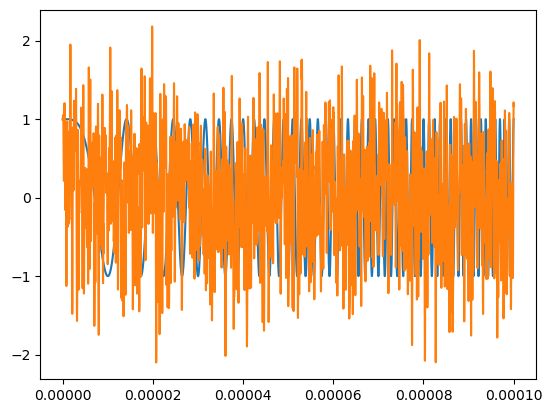

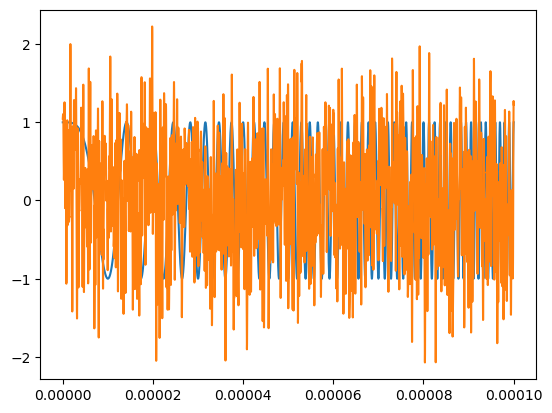

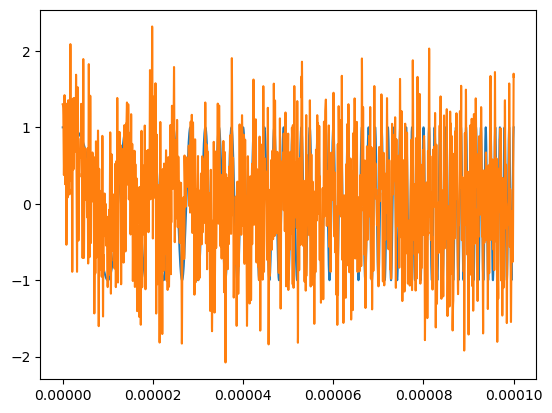

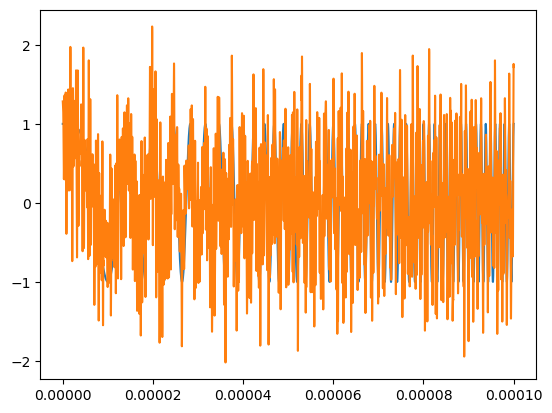

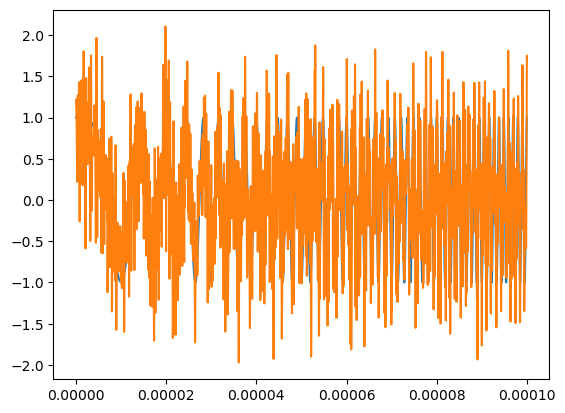

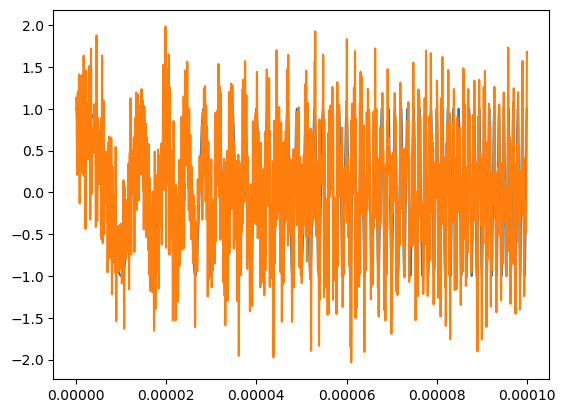

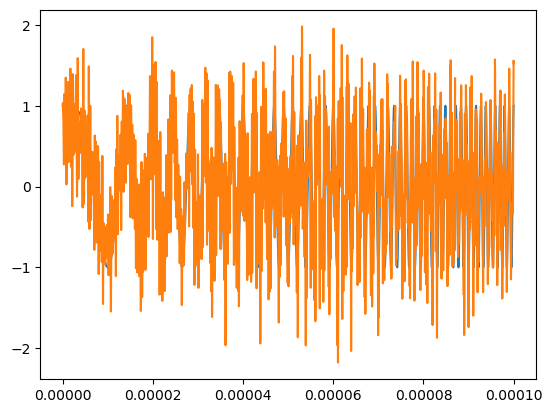

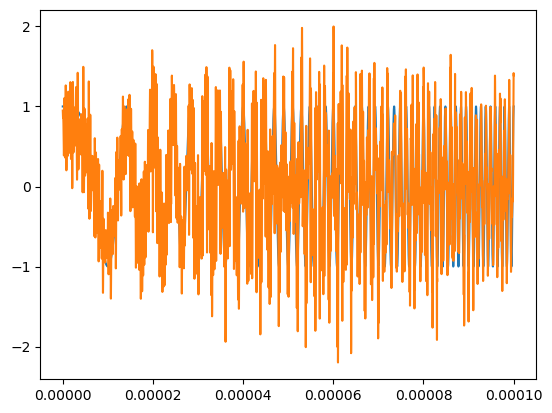

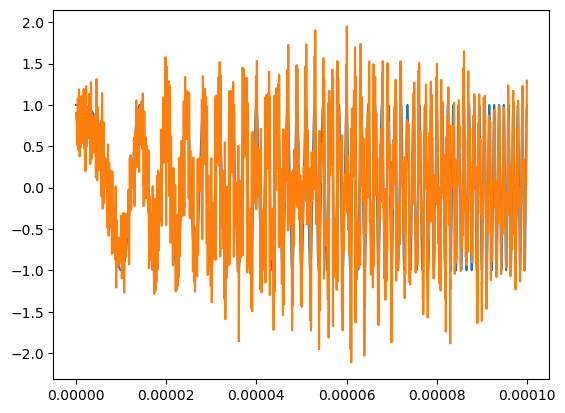

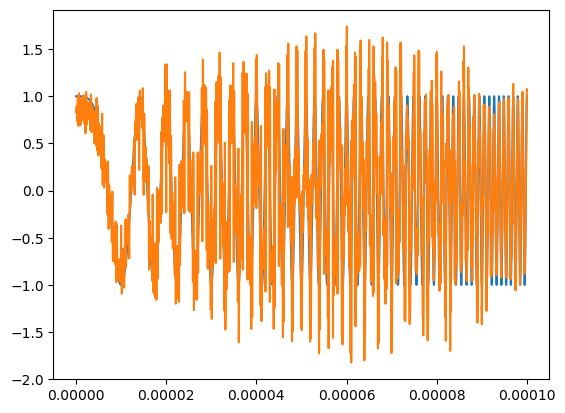

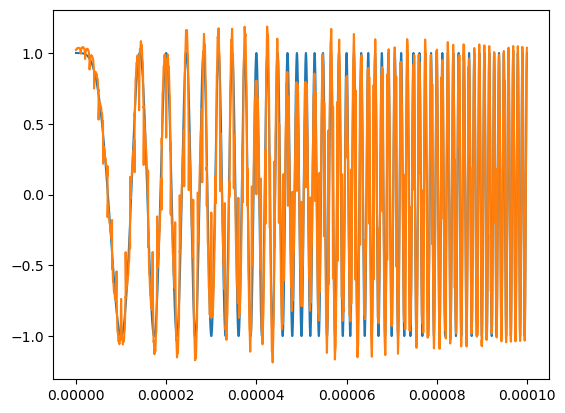

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch
from multiprocessing import Pool
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
# radar_pulse = myRadarPulses.Gaussian_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

def total_max_power_constr(coff):
     return torch.sum(torch.abs(coff)**2) - Ptotal/Tb

def get_mse(coff):
    s = torch.sum(coff[:, None] * g_vec, dim=0)
    s = s / torch.sqrt(torch.mean(s.abs()**2))
    return torch.mean(torch.abs(s - radar_pulse / torch.sqrt(torch.mean(radar_pulse.abs()**2))) ** 2) # Compute MSE loss
    # return torch.mean(torch.abs(s - radar_pulse) ** 2) # Compute MSE loss

def get_gamma(coff):
    return (torch.abs(coff)**2).reshape((L, K)).sum(dim=0) * Tb / sigma2 #for OFDMA and CDMA

# Fitness function
def cost_function(coff, coff_old, dual_lambda, theta):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """

    sumrate = torch.sum(torch.log2(1 + get_gamma(coff)))
    sumrate_old = torch.sum(torch.log2(1 + get_gamma(coff_old)))
    return theta*get_mse(coff) - (1-theta)*sumrate+ dual_lambda*(total_max_power_constr(coff))

# Initialize individual with real and imaginary parts
init_c = torch.rand(K * L * 2, device=device, requires_grad=True) * 2 - 1
real_val = init_c[:len(init_c)//2]  # Real part
imag_val = init_c[len(init_c)//2:]  # Imaginary part
# Combine real and imaginary parts into complex tensor
c = real_val + 1j * imag_val  # Combine parts to form a complex number

c.retain_grad()

dual = 0
dual_update_rate = 1e-5
Theta = np.linspace(0,1,11)
MSEs = np.zeros(len(Theta))
SumRates = np.zeros(len(Theta))
for idx, theta in tqdm(enumerate(Theta)):
    primal_update_rate = 5e-2 * theta * 10
    for itr in range(50000):

        # Call the fitness function with the complex individual
        c_old = c.detach()
        cost = cost_function(c, c_old, dual, theta)
        
        # Backpropagate to compute gradients
        cost.backward(retain_graph=True)
        delta_x = -c.grad
        t_coff = 1
        alpha = 0.005
        beta = 0.9

        with torch.no_grad():
            loop_cont = 0
            for _ in range(1000):
                loop_cont += 1
                new_cost = cost_function(c + t_coff*delta_x, c_old, dual, theta).item()
                old_cost = cost.item()
                if new_cost <= old_cost - alpha*t_coff*torch.sum(delta_x.abs()**2):
                    break
                else:
                    t_coff *= beta

            if torch.linalg.norm(t_coff * delta_x) < 1e-5:
                print("Early Stopping")
                break
            
            c += t_coff * delta_x  # Update rule
            dual = max(0, dual + dual_update_rate * total_max_power_constr(c))
            
            if itr % 1000 == 0:
                print(f"Iteration {itr}: constraint value = {total_max_power_constr(c).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}, UpdateDistance:{torch.linalg.norm(t_coff * delta_x)}")
                print(f'\t----> sumRate = {torch.sum(torch.log2(1 + get_gamma(c))).item():0.3f}, MSE = {get_mse(c).item():0.3f}')    

        c.grad.zero_()
    

    c_opt = c.detach()
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    MSEs[idx] = get_mse(c_opt).item()
    SumRates[idx] = torch.sum(torch.log2(1 + get_gamma(c_opt))).cpu().numpy()
    print(f"====END {itr}: constraint value = {total_max_power_constr(c_opt).item():0.3f}, Dual Variable = {dual:0.3f}, Cost = {cost.item():0.3f}, UpdateDistance:{torch.linalg.norm(t_coff * delta_x)}")
    print(f'\t----> sumRate = {SumRates[idx]:0.3f}, MSE = {MSEs[idx]:0.3f}')  
    user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
    user_energy = user_bit_energy.sum(dim=0)
    print(f'Users\' Powers:{10*torch.log10(user_energy).cpu().numpy()+30} dBm ----->> SumPower : {10*torch.log10(user_energy.sum()).cpu().numpy()+30}')
    print(f'Sigma2 Power:{10*np.log10(sigma2)+30} dBm')

    plt.figure()
    plt.plot(t.cpu(), (radar_pulse/torch.sqrt(torch.mean(radar_pulse.abs()**2))).cpu().real)
    plt.plot(t.cpu(), (s_opt/torch.sqrt(torch.mean(s_opt.abs()**2))).cpu().real)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

# Fitness function
def fitness_fn(individual):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """
    N = len(individual) // 2
    # individual = np.clip(individual, -1, 1)
    real_val = torch.tensor(individual[:N], device=device, dtype=torch.float32)
    imag_val = torch.tensor(individual[N:], device=device, dtype=torch.float32)
    
    # Combine real and imaginary parts into complex tensor
    c_opt = real_val + 1j * imag_val
    c_opt = c_opt.to(torch.complex64)
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    s_opt_normalized = s_opt
    radar_pulse_normalized = radar_pulse
    mse = (torch.mean(torch.abs(s_opt_normalized - radar_pulse_normalized) ** 2)).item()
    return mse,

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, L * K * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=20)

# Genetic algorithm execution
population = toolbox.population(n=500)
n_generations = 1000

stats = Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", lambda a: np.mean(a))
stats.register("Min", lambda a: np.min(a))
# Run the genetic algorithm
result, log = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations, verbose=True, stats=stats
)

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
N = len(best_individual) // 2
real_val = torch.tensor(best_individual[:N], device=device, dtype=torch.float32)
imag_val = torch.tensor(best_individual[N:], device=device, dtype=torch.float32)

# Combine real and imaginary parts into complex tensor
c_opt_optimized = real_val + 1j * imag_val
c_opt_optimized = c_opt_optimized.to(torch.complex64).to(device)

# Synthesize optimized signal
s_opt_optimized = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

In [ ]:
radar_pulse_power = (radar_pulse.abs()**2).sum()
s_opt_optimized2 = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0) * torch.sqrt(radar_pulse_power / (s_opt_optimized.abs()**2).sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized2.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

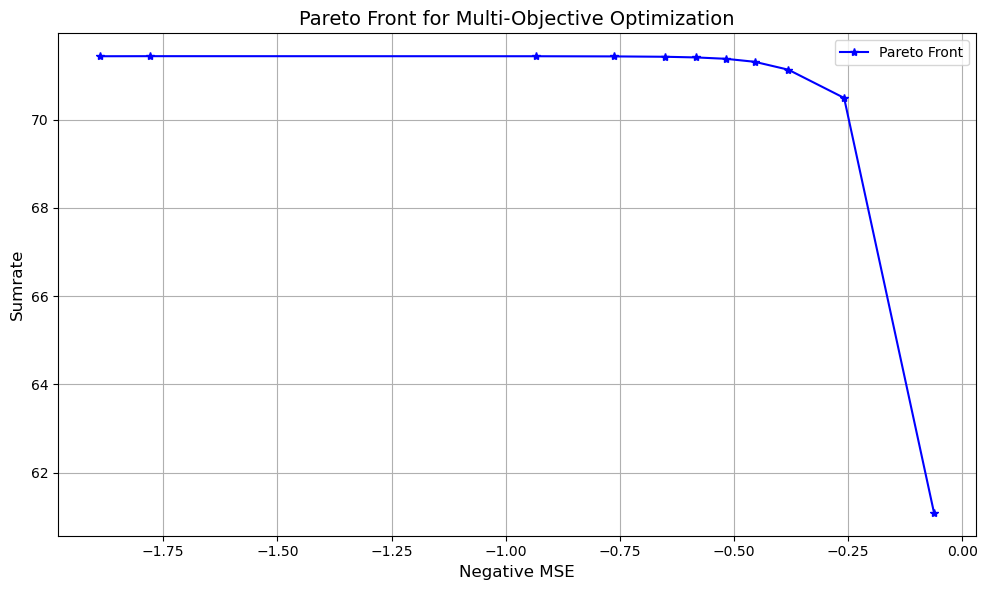

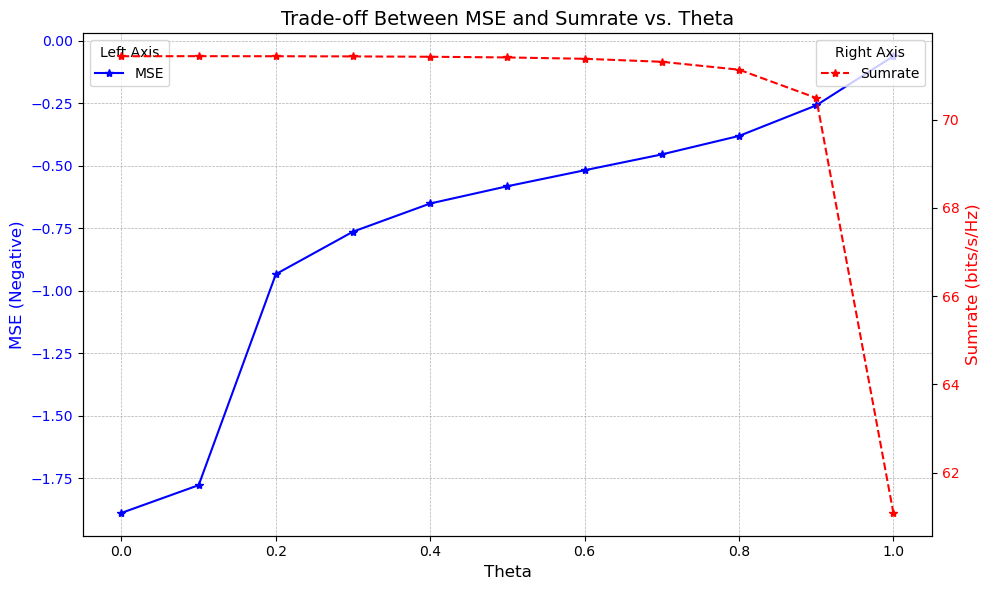

In [31]:
plt.figure(figsize=(10, 6))
plt.grid()

# Plot the Pareto Front
plt.plot(-MSEs, SumRates, '*-', label="Pareto Front", color="b")

# Fill the area under the Pareto points
# plt.fill_between(-MSEs, SumRates, alpha=0.3, color="blue", label="Feasible Region")
# plt.ylim([1*min(SumRates), 1.05*max(SumRates)])
# Add labels, title, and legend
plt.xlabel("Negative MSE", fontsize=12)
plt.ylabel("Sumrate", fontsize=12)
plt.title("Pareto Front for Multi-Objective Optimization", fontsize=14)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


# Create a figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE (left y-axis)
ax1.plot(Theta, -MSEs, 'b*-', label="MSE")
ax1.set_xlabel('Theta', fontsize=12)
ax1.set_ylabel('MSE (Negative)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b', labelsize=10)
ax1.set_title("Trade-off Between MSE and Sumrate vs. Theta", fontsize=14)

# Create a secondary y-axis for Sumrate
ax2 = ax1.twinx()
ax2.plot(Theta, SumRates, 'r*--', label="Sumrate")
ax2.set_ylabel('Sumrate (bits/s/Hz)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r', labelsize=10)

# Add legends for both axes
ax1.legend(loc="upper left", fontsize=10, title="Left Axis")
ax2.legend(loc="upper right", fontsize=10, title="Right Axis")

# Add grid for clarity
ax1.grid(visible=True, which="major", linestyle="--", linewidth=0.5)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()
